# CNN (畳み込みニューラルネットワーク)

Convolution層(畳み込み層)、Pooling層（プーリング層)などの層が特徴的。

In [16]:
# ライブラリのインポート
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializations
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

## データの準備

In [5]:
# 分類クラス数
nb_classes = 72

# データの読み込み
ary = np.load("./../data/hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32) / 15
ary.shape

# 入力データの取得
# サイズを変換する (127, 128) => (32, 32)
img_height, img_width = 32, 32

X_data = np.zeros([nb_classes * 160, img_height, img_width], dtype=np.float32)
for i in range(nb_classes * 160):
    # 画像をリサイズする
    X_data[i] = scipy.misc.imresize(ary[i], (img_height, img_width), mode='F')
Y_data = np.repeat(np.arange(nb_classes), 160)

del ary

# CNNに合わせるためにreshape
# (11520, 32, 32) => (11520, 32, 32, 1)
X_data = X_data.reshape(X_data.shape[0], img_height, img_width, 1)

# データセットをトレーニングセットとCVに分ける（8:2)
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2)

# one-hot vectorに変換する
def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int').ravel()
    if not nb_classes:
        nb_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, nb_classes))
    categorical[np.arange(n), y] = 1
    return categorical

Y_train0_old = Y_train[0]
Y_train = to_categorical(Y_train, nb_classes)
Y_val = to_categorical(Y_val, nb_classes)

# 表示
print('train set:', X_train.shape, Y_train.shape)
print('cv set:', X_val.shape, Y_val.shape)

train set: (9216, 32, 32, 1) (9216, 72)
cv set: (2304, 32, 32, 1) (2304, 72)


## モデルの作成

In [17]:
# カスタム初期化
def custom_init(shape, name=None):
    return initializations.normal(shape, scale=0.1, name=name)

In [18]:
# モデルの作成(VGG風)
model = Sequential()

model.add(Convolution2D(32, 3, 3, init=custom_init, input_shape=(32, 32, 1))) # filter数, filterの縦幅、filterの横幅
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3, init=custom_init))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, init=custom_init))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, init=custom_init))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, init=custom_init))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [8]:
# エポック単位に自動的に重みを保存する
checkpoint_collback = ModelCheckpoint(
    filepath='/tmp/model.hdf5',
    monitor='val_loss',
    save_best_only=True,
    mode='auto')

In [21]:
# EarlyStopping: patience回連続でコストの最小値が更新されない場合ストップ
early_stop = EarlyStopping(patience=100)

In [20]:
# 最適化とコスト
model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy'])

In [19]:
# DataAugumentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.20)
datagen.fit(X_train)

In [22]:
# トレーニング
hist = model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=16),
    samples_per_epoch=X_train.shape[0],
    nb_epoch=500,
    callbacks=[checkpoint_collback, early_stop],
    validation_data=(X_val, Y_val))

Epoch 1/500
9216/9216 [==============================] - 66s - loss: 4.2371 - acc: 0.0255 - val_loss: 4.0681 - val_acc: 0.0916
Epoch 2/500
9216/9216 [==============================] - 84s - loss: 3.8963 - acc: 0.0756 - val_loss: 3.2908 - val_acc: 0.3411
Epoch 3/500
9216/9216 [==============================] - 79s - loss: 3.3768 - acc: 0.1553 - val_loss: 2.3864 - val_acc: 0.5191
Epoch 4/500
9216/9216 [==============================] - 62s - loss: 2.8581 - acc: 0.2451 - val_loss: 1.8336 - val_acc: 0.6202
Epoch 5/500
9216/9216 [==============================] - 61s - loss: 2.4647 - acc: 0.3264 - val_loss: 1.4134 - val_acc: 0.6940
Epoch 6/500
9216/9216 [==============================] - 61s - loss: 2.1775 - acc: 0.3867 - val_loss: 1.1478 - val_acc: 0.7439
Epoch 7/500
9216/9216 [==============================] - 61s - loss: 1.9308 - acc: 0.4425 - val_loss: 0.9736 - val_acc: 0.7626
Epoch 8/500
9216/9216 [==============================] - 61s - loss: 1.7203 - acc: 0.4974 - val_loss: 0.7585 - 

g2.2xlarge (1 Epoch 8s程度)

```
Epoch 1/500
9216/9216 [==============================] - 8s - loss: 4.2577 - acc: 0.0205 - val_loss: 4.1268 - val_acc: 0.1102
Epoch 2/500
9216/9216 [==============================] - 8s - loss: 3.9113 - acc: 0.0748 - val_loss: 3.2396 - val_acc: 0.3242
Epoch 3/500
9216/9216 [==============================] - 8s - loss: 3.3561 - acc: 0.1603 - val_loss: 2.2879 - val_acc: 0.5182
Epoch 4/500
9216/9216 [==============================] - 8s - loss: 2.8414 - acc: 0.2580 - val_loss: 1.6689 - val_acc: 0.6558
Epoch 5/500
9216/9216 [==============================] - 8s - loss: 2.4566 - acc: 0.3279 - val_loss: 1.3113 - val_acc: 0.7140
...
```

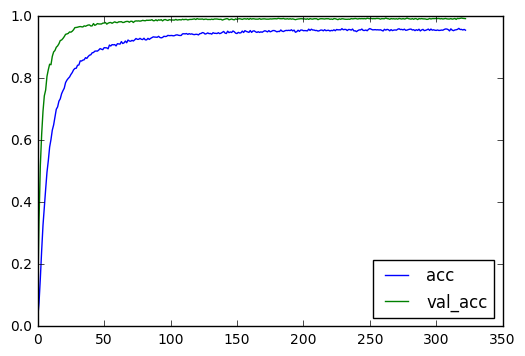

In [30]:
xlin = np.arange(323)
plt.plot(xlin, hist.history['acc'])
plt.plot(xlin, hist.history['val_acc'])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()